<a href="https://colab.research.google.com/github/treasure-data/td-notebooks/blob/master/machine-learning/churn/decision_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Summary

This notebook shows how to classify churn users with Decision Tree in Hivemall.  
As for the dataset, please refer [this article](https://aws.amazon.com/blogs/machine-learning/predicting-customer-churn-with-amazon-machine-learning/)  

# SetUp

Executing a following cell, you are asked to input some information.

In [0]:
from getpass import getpass
td_api_key = getpass('Enter TD API KEY here ')
database   = input('Enter YOUR DATABASE to create tables here ')
assert database, "Error: Input YOUR DATABASE"
endpoint   = input('Enter YOUR ENDPOINT to create tables here (default: "api.treasuredata.com") \nref : https://support.treasuredata.com/hc/en-us/articles/360001474288-Sites-and-Endpoints ')
endpoint = endpoint if endpoint else 'https://api.treasuredata.com/'
endpoint = 'https://' + endpoint if not endpoint.startswith('https://') else endpoint
use_spark  = input('If enable to use spark, enter "true" (default: false) ').lower()
use_spark  = use_spark == 'true'
table = 'churn_dataset'

Enter TD API KEY here ··········
Enter YOUR DATABASE to create tables here hivemall
Enter YOUR ENDPOINT to create tables here (default: "api.treasuredata.com") 
ref : https://support.treasuredata.com/hc/en-us/articles/360001474288-Sites-and-Endpoints 
If enable to use spark, enter "true" (default: false) 


In [0]:
%%capture
!pip install td-client
!pip install pandas-td
!pip install -q git+https://github.com/takuti/pytd@master#egg=treasure-data[spark]

import numpy as np
import pandas as pd
import pandas_td as td
import matplotlib.pyplot as plt
import seaborn as sns
import pytd
import tdclient
pd.options.display.max_columns = 30

%matplotlib inline
con = td.connect(apikey=td_api_key, endpoint=endpoint)
c = tdclient.Client(apikey=td_api_key, endpoint=endpoint)
presto = td.create_engine('presto:{}'.format(database), con=con)
hive = td.create_engine('hive:{}'.format(database), con=con)

def recreate_table(client, table, database=database):
  if table in [table.name for table in client.tables(database)]:
    client.delete_table(database, table)
  client.create_log_table(database, table)
  return None

# Data Preparation

A cell below will create a table on your Treasure Data account.  
This cell takes a little long time (5min.)

In [0]:
%%capture
!wget http://dataminingconsultant.com/DKD2e_data_sets.zip
!unzip -o DKD2e_data_sets.zip

In [0]:
df = pd.read_csv('./Data sets/churn.txt')
df.columns = ['state','account_length','area_code','phone','intl_plan','vmail_plan','vmail_message','day_mins','day_calls','day_charge','eve_mins','eve_calls','eve_charge','night_mins','night_calls','night_charge','intl_mins','intl_calls','intl_charge','cust_serv_calls','is_churn']

In [0]:
if use_spark:
  client = pytd.Client(database=database, apikey=td_api_key)
  client.load_table_from_dataframe(df.reset_index(), '{}.{}'.format(database, table), if_exists='overwrite')
else:
  if table in [table.name for table in c.tables(database)]:
    c.delete_table(database, table)
  td.to_td(df, '{}.{}'.format(database, table), con)

Check the created table.

In [0]:
td.read_td_query('''
select
  is_churn,state,account_length,area_code,phone,intl_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,eve_mins,eve_calls,eve_charge,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,cust_serv_calls
from
  churn_dataset
limit 2
''', engine=presto)

,is_churn,state,account_length,area_code,phone,intl_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,eve_mins,eve_calls,eve_charge,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,cust_serv_calls
0,False.,WI,93,415,392-6286,no,no,0,152.1,141,25.86,215.5,107,18.32,262.4,111,11.81,12.0,7,3.24,1
1,False.,OK,149,510,365-9079,yes,no,0,180.9,79,30.75,194.9,83,16.57,197.8,109,8.90,8.8,9,2.38,3


**Columns**
- state: the US state in which the customer resides, indicated by a two-letter abbreviation; for example, OH or NJ
- account_length: the number of days that this account has been active
- area_code: the three-digit area code of the corresponding customer’s phone number
- phone: the remaining seven-digit phone number
- intl_plan: whether the customer has an international calling plan: yes/no
- vmail_plan: whether the customer has a voice mail feature: yes/no
- vmail_message: presumably the average number of voice mail messages per month
- day_mins: the total number of calling minutes used during the day
- day_calls: the total number of calls placed during the day
- day_charge: the billed cost of daytime calls
- eve_mins, eve_calls, eve_charge: the billed cost for calls placed during the evening
- night_mins, night_calls, night_charge: the billed cost for calls placed during nighttime
- intl_mins, intl_calls, intl_charge: the billed cost for international calls
- cust_serv_calls: the number of calls placed to Customer Service
- is_churn: whether the customer left the service: true/false

# EDA (Explore Data Analysis)
Before running machine learning tasks, you should understand your data correctly.  
Descriptive statistics and visualization are important for this.

## Data Size

In [0]:
td.read_td_query('''
select
  count(*)
from
  churn_dataset
''', engine=presto)

,_col0
0,3333


## Check if null value exists

In [0]:
td.read_td_query('''
select
  count(is_churn) as is_churn,
  count(state) as state,
  count(account_length) as account_length,
  count(area_code) as area_code,
  count(phone) as phone,
  count(intl_plan) as intl_plan,
  count(vmail_plan) as vmail_plan,
  count(vmail_message) as vmail_message,
  count(day_mins) as day_mins,
  count(day_calls) as day_calls,
  count(day_charge) as day_charge,
  count(eve_mins) as eve_mins,
  count(eve_calls) as eve_calls,
  count(eve_charge) as eve_charge,
  count(night_mins) as night_mins,
  count(night_calls) as night_calls,
  count(night_charge) as night_charge,
  count(intl_mins) as intl_mins,
  count(intl_calls) as intl_calls,
  count(intl_charge) as intl_charge,
  count(cust_serv_calls) as cust_serv_calls
from
  churn_dataset
''', engine=presto)

,is_churn,state,account_length,area_code,phone,intl_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,eve_mins,eve_calls,eve_charge,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,cust_serv_calls
0,3333,3333,3333,3333,3333,3333,3333,3333,3333,3333,3333,3333,3333,3333,3333,3333,3333,3333,3333,3333,3333


Null value is not found.

## Target Variable

In [0]:
td.read_td_query('''
select
  is_churn
  ,count(*) as n
from
  churn_dataset
group by
  1
''', engine=presto)

,is_churn,n
0,True.,483
1,False.,2850


## state(string)

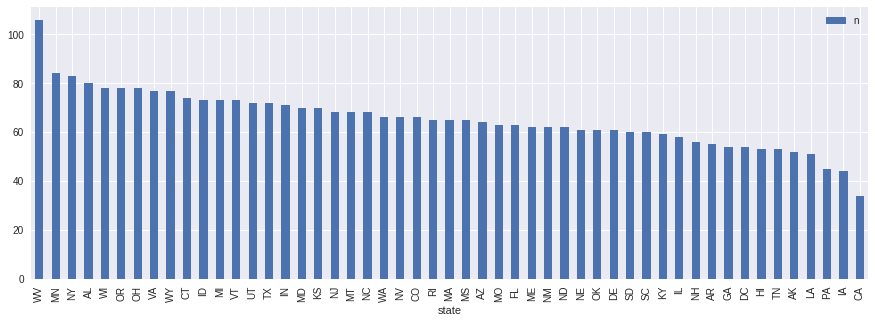

In [0]:
td.read_td_query('''
select
  state
  ,count(*) as n
from
  churn_dataset
group by
  1
order by
  2 desc
''', engine=presto, index_col='state').plot.bar(figsize=(15,5))

## account_length (int)

In [0]:
td.read_td_query('''
select
  avg(account_length) as average
  ,min(account_length) as min
  ,approx_percentile(account_length, 0.25) as pct_25th
  ,approx_percentile(account_length, 0.50) as pct_50th
  ,approx_percentile(account_length, 0.75) as pct_75th
  ,max(account_length) as max
from
  churn_dataset
''', engine=presto)

,average,min,pct_25th,pct_50th,pct_75th,max
0,101.064806,1,74,101,127,243


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f51f86d69e8>]],
      dtype=object)

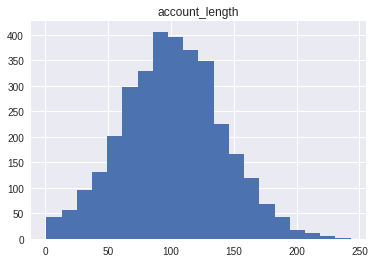

In [0]:
td.read_td_query('''
  select
    account_length
  from
    churn_dataset
''', engine=presto).hist(bins=20)

## area_code (string)

In [0]:
td.read_td_query('''
select
  area_code
  ,count(*) as n
from
  churn_dataset
group by
  1
order by
  2 desc
''', engine=presto)

,area_code,n
0,415,1655
1,510,840
2,408,838


## phone(string)
This column is unique for each row. So, this cannot be used for machine learning.

In [0]:
td.read_td_query('''
select
  count(phone) as n
  ,count(distinct phone) as n_unique
from
  churn_dataset
''', engine=presto)

,n,n_unique
0,3333,3333


## intl_plan(string)

In [0]:
td.read_td_query('''
select
  intl_plan
  ,count(*) as n
from
  churn_dataset
group by
  1
order by
  2 desc
''', engine=presto)

,intl_plan,n
0,no,3010
1,yes,323


## vmail_plan(string)

In [0]:
td.read_td_query('''
select
  vmail_plan
  ,count(*) as n
from
  churn_dataset
group by
  1
order by
  2 desc
''', engine=presto)

,vmail_plan,n
0,no,2411
1,yes,922


## vmail_message(int)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7ef8e75358>]],
      dtype=object)

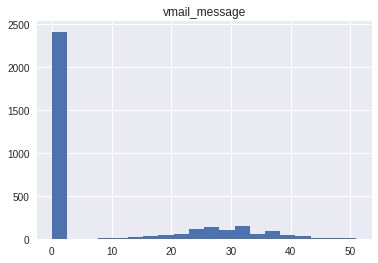

In [0]:
td.read_td_query('''
select
  vmail_message
from
  churn_dataset
''', engine=presto).hist(bins=20)

## day_mins(double)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f51f3a9ef28>]],
      dtype=object)

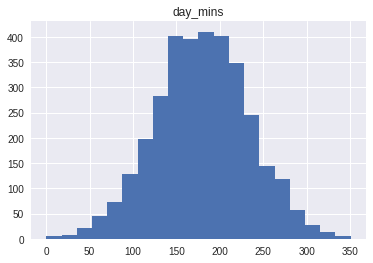

In [0]:
td.read_td_query('''
select
  day_mins
from
  churn_dataset
''', engine=presto).hist(bins=20)

## day_calls(int)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f51f3a41080>]],
      dtype=object)

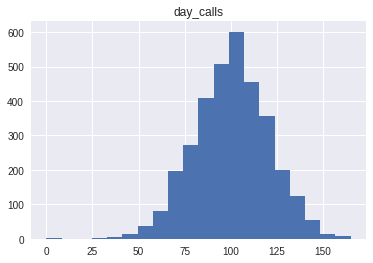

In [0]:
td.read_td_query('''
select
  day_calls
from
  churn_dataset
''', engine=presto).hist(bins=20)

## day_charge(double)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f51f39a2b38>]],
      dtype=object)

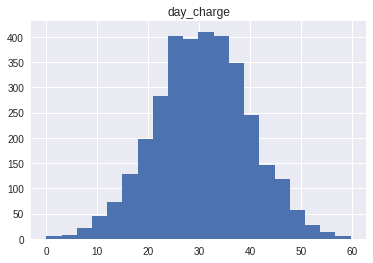

In [0]:
td.read_td_query('''
select
  day_charge
from
  churn_dataset
''', engine=presto).hist(bins=20)

## eve_mins(double)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f51f39599e8>]],
      dtype=object)

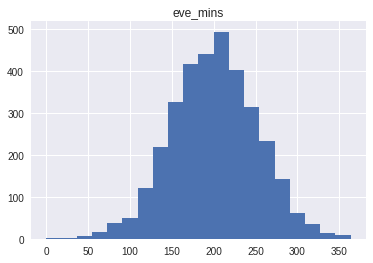

In [0]:
td.read_td_query('''
select
  eve_mins
from
  churn_dataset
''', engine=presto).hist(bins=20)

## eve_calls(int)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f51f3a076a0>]],
      dtype=object)

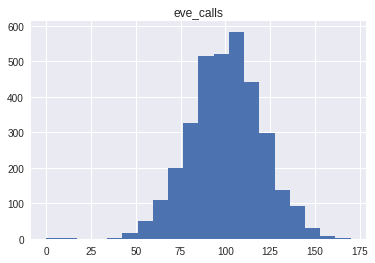

In [0]:
td.read_td_query('''
select
  eve_calls
from
  churn_dataset
''', engine=presto).hist(bins=20)

## eve_charge(double)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f51f3827e80>]],
      dtype=object)

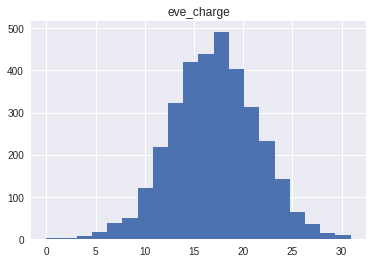

In [0]:
td.read_td_query('''
select
  eve_charge
from
  churn_dataset
''', engine=presto).hist(bins=20)

## night_mins(double)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f51f377d7f0>]],
      dtype=object)

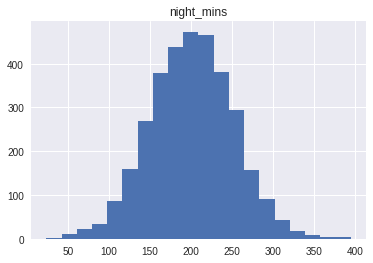

In [0]:
td.read_td_query('''
select
  night_mins
from
  churn_dataset
''', engine=presto).hist(bins=20)

## night_calls(int)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f51f366b4e0>]],
      dtype=object)

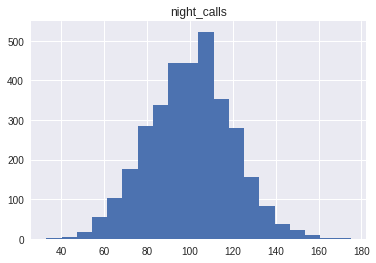

In [0]:
td.read_td_query('''
select
  night_calls
from
  churn_dataset
''', engine=presto).hist(bins=20)

## night_charge(double)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f51f5c91f28>]],
      dtype=object)

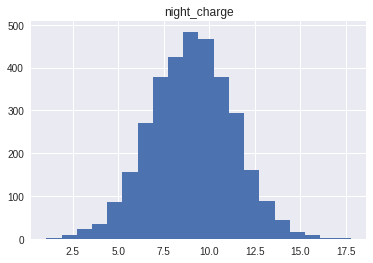

In [0]:
td.read_td_query('''
select
  night_charge
from
  churn_dataset
''', engine=presto).hist(bins=20)

## intl_mins(double)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f51f35c7e80>]],
      dtype=object)

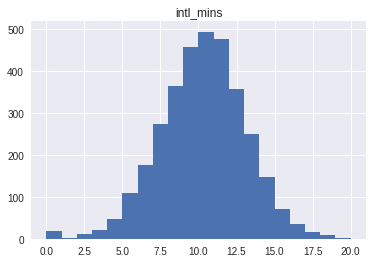

In [0]:
td.read_td_query('''
select
  intl_mins
from
  churn_dataset
''', engine=presto).hist(bins=20)

## intl_calls(int)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f51f353a470>]],
      dtype=object)

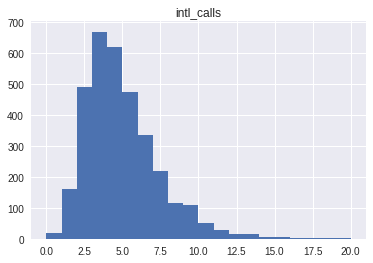

In [0]:
td.read_td_query('''
select
  intl_calls
from
  churn_dataset
''', engine=presto).hist(bins=20)

## intl_charge (double)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f51f3469550>]],
      dtype=object)

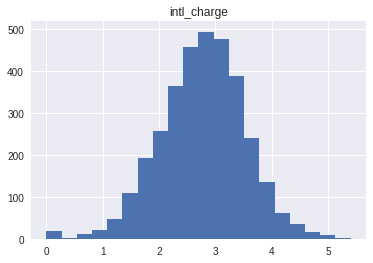

In [0]:
td.read_td_query('''
select
  intl_charge
from
  churn_dataset
''', engine=presto).hist(bins=20)

## cust_serv_calls

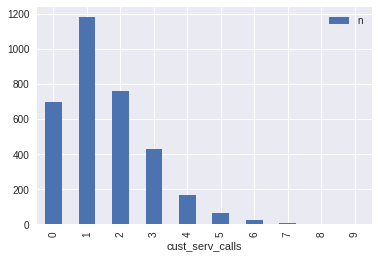

In [0]:
td.read_td_query('''
select
  cust_serv_calls
  ,count(*) as n
from
  churn_dataset
group by
  1
''', engine=presto, index_col='cust_serv_calls').sort_index().plot.bar()

## Correlations
With python library, you can visuazlie the relashionship between variables.

In [0]:
df = td.read_td_query('''
  select
    case when is_churn like 'True.' then 1 else 0 end as is_churn
    ,state,account_length,area_code,intl_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,eve_mins,eve_calls,eve_charge,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,cust_serv_calls
  from
    churn_dataset    
''', engine=presto)

### Scatter plot

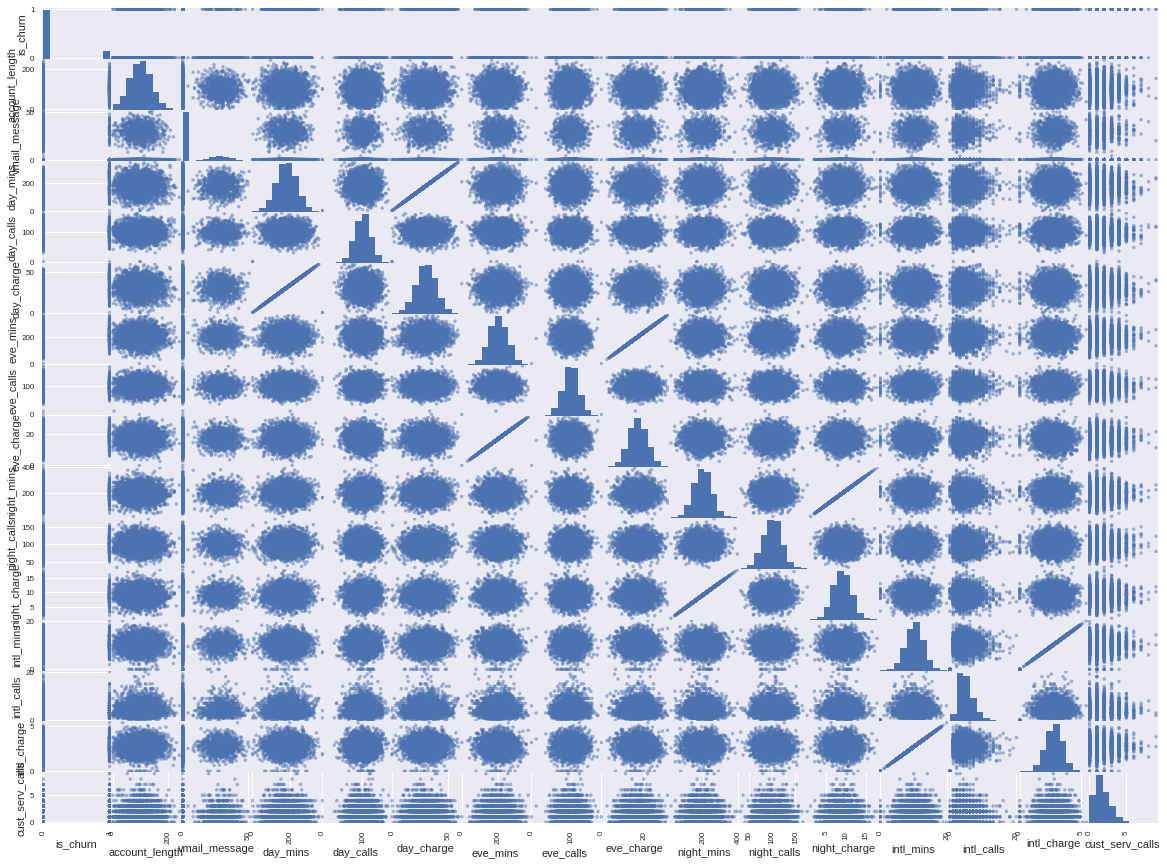

In [0]:
pd.plotting.scatter_matrix(df, figsize=(20,15))
plt.show()

### Correlatiion coefficient matrix

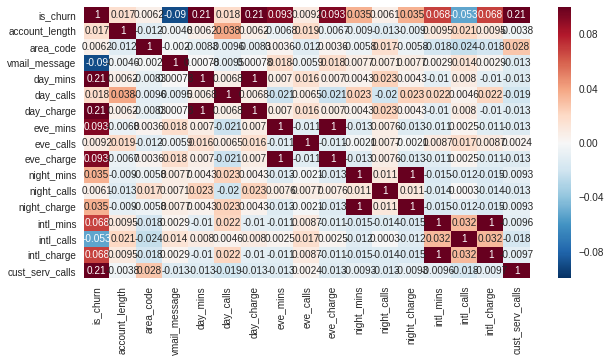

In [0]:
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(df.corr(), annot=True, ax=ax, vmin=-0.1, vmax=0.1)
plt.show()

The correlation coefficients of pairs (day_mins, day_charge) , (eve_mins, eve_charge), (intl_mins, intl_charge) equals `1.0`.  
You should remove one of elements from feature variables because of [multicollinearity](https://en.wikipedia.org/wiki/Multicollinearity).

# Run a machine learning task

## Preprocess

- Data is splitted into training data and test data. The number of rows for each `state` coliumns' value is less,
- String columns are expanded to binary columns.
- Remove unnecessary columns in consideration of [EDA](https://colab.research.google.com/drive/1k062r8-jXhlnU_vjbHCI-Z_yGxt96iE2#scrollTo=CEqJzaJ-rC78)

In [0]:
recreate_table(c, 'churn_preprocessed')

In [0]:
df = td.read_td_query('''
with add_num as (
  select
    row_number() over() as rownum
    ,*
  from
    churn_dataset
)

,target as (
  select
    rownum
    ,case when is_churn like 'False.' then 0 else 1 end as target
    ,case when rand() < 0.8 then 'train' else 'test' end as class
  from
    add_num
)

,features as (
  select
    quantify(true,
             rownum,state,area_code,intl_plan,vmail_plan,account_length,vmail_message,day_calls,eve_calls,night_calls,intl_calls,cust_serv_calls,day_mins,eve_mins,night_mins,intl_mins
             ) as (rownum,state,area_code,intl_plan,vmail_plan,account_length,vmail_message,day_calls,eve_calls,night_calls,intl_calls,cust_serv_calls,day_mins,eve_mins,night_mins,intl_mins)
  from
    add_num
)

insert overwrite table churn_preprocessed
select
  target.rownum
  ,target.class
  ,target.target
  ,array(state,area_code,intl_plan,vmail_plan,account_length,vmail_message,day_calls,eve_calls,night_calls,intl_calls,cust_serv_calls,day_mins,eve_mins,night_mins,intl_mins) as features
  ,state,area_code,intl_plan,vmail_plan,account_length,vmail_message,day_calls,eve_calls,night_calls,intl_calls,cust_serv_calls,day_mins,eve_mins,night_mins,intl_mins
from
  target
  left outer join
  features
  on
    target.rownum = features.rownum
''', engine=hive)

Check the created table.

In [0]:
td.read_td_query('''
select
  *
from
  churn_preprocessed
limit 2
''', engine=presto)

UsageError: Cell magic `%%td_presto` not found.


## Build a decision tree

In [0]:
recreate_table(c, 'churn_dt_model')

In [0]:
td.read_td_query('''
insert overwrite table churn_dt_model
select
  train_randomforest_classifier(
    features,
    target,
    '-attrs C,C,C,C,Q,Q,Q,Q,Q,Q,Q,Q,Q,Q,Q -trees 1 -depth 4 -vars 15'
  )
from
  churn_preprocessed
where
  class like 'train'
''', engine=hive)

,model_id,model_weight,model,var_importance,oob_errors,oob_tests


Check the created table.

In [0]:
td.read_td_query('''
select
  model_id, model_weight, model
from
  churn_dt_model
''', engine=presto)

,model_id,model_weight,model
0,3db40cc7-6033-4aa1-8b58-256e2f1093b3,0.876133,I?z:MQ}ek*KCWQFBrIg-zvouvN_h!IHDN1:aNtCt-?f5pu...


### Visualize the tree

The `model` column of `churn_dt_model` table includes a detail of tree.

In [0]:
f = open('tree.dot', 'w')
tree = td.read_td_query('''select
  model_id,
  tree_export(model, "-type graphviz", array('state','area_code','intl_plan','vmail_plan','account_length','vmail_message','day_calls','eve_calls','night_calls','intl_calls','cust_serv_calls','day_mins','eve_mins','night_mins','intl_mins'), array('0','1')) as dot
from
  churn_dt_model
''', engine=hive)['dot'][0]
f.write(tree)
f.close()

In [0]:
!dot -Tpng tree.dot -o tree.png

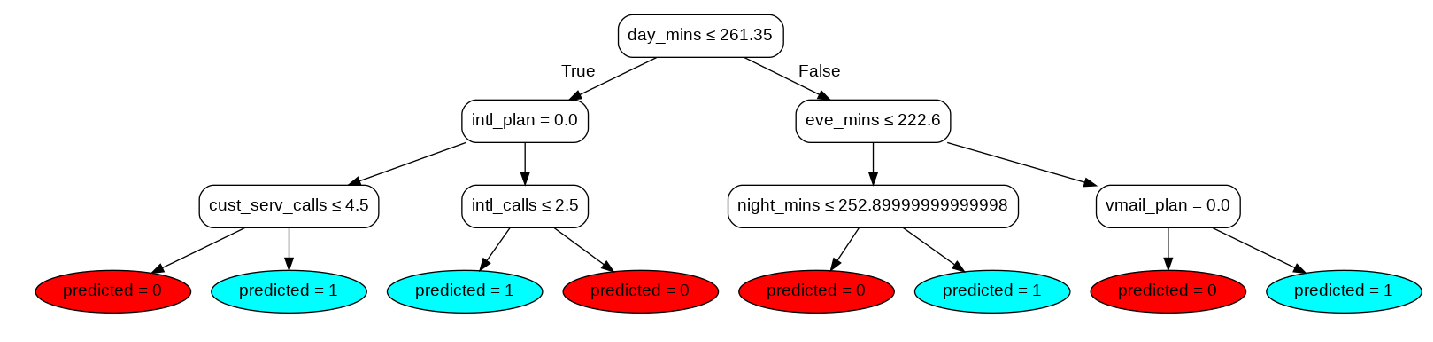

In [0]:
from PIL import Image
im = Image.open("tree.png", "r")
fig, ax = plt.subplots(figsize=(25,50))
ax.imshow(np.array(im));ax.axis('off');plt.show()

Let's confirm how many users are classified by the first condition branch, `cust_serv_calls <= 3.5`, 

                        churn_rate     n
condition                               
cust_serv_calls <= 3.5    0.112524  3066
cust_serv_calls > 3.5     0.516854   267


UsageError: Line magic function `%plt.show` not found.


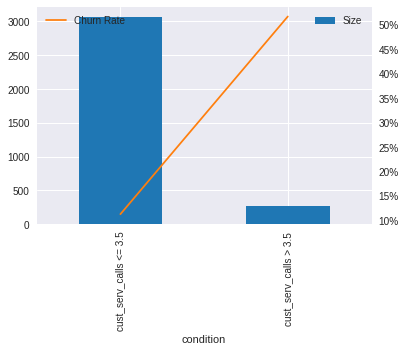

In [0]:
df = td.read_td_query('''
select
  case when cust_serv_calls < 3.5 then 'cust_serv_calls <= 3.5' else 'cust_serv_calls > 3.5' end as condition
  ,cast(sum(target) as double) / count(*) as churn_rate
  ,count(*) as n
from
  churn_preprocessed
group by
  1''', engine=presto, index_col='condition')

print(df)

fig, ax = plt.subplots();_ax=ax.twinx()
df['n'].plot.bar(ax=ax, color='tab:blue', label='Size')
df['churn_rate'].plot(ax=_ax, color='tab:orange', label='Churn Rate')
ax.legend();_ax.legend(loc=0);_ax.grid(False);_ax.set_yticklabels(['{:,.0%}'.format(x) for x in _ax.get_yticks()]);
%plt.show()

The condition seems to classify users to cancel their contract and ones not to cancel.

#### Check the variable importance.

In [0]:
df = td.read_td_query('''
select
  num
  ,subarray(array('state','area_code','intl_plan','vmail_plan','account_length','vmail_message','day_calls','eve_calls','night_calls','intl_calls','cust_serv_calls','day_mins','eve_mins','night_mins','intl_mins'), num - 1, num)[0] as feature
  ,subarray(var_importance, num - 1, num)[0] as importance
from
  churn_dt_model
lateral view
  generate_series(1,15) t as num
order by
  importance desc
''', engine=hive)

## Prediction

In [0]:
recreate_table(c, 'churn_dt_pred')

In [0]:
td.read_td_query('''
insert overwrite table churn_dt_pred
SELECT
  rownum,
  class,
  target,
  rf_ensemble(predicted.value, predicted.posteriori, model_weight).probabilities[1] as predicted
FROM (
  SELECT
    t.rownum, 
    class,
    target,
    p.model_weight,
    tree_predict(p.model_id, p.model, t.features, "-classification") as predicted
  FROM (
    SELECT 
      model_id, model_weight, model
    FROM 
      churn_dt_model
    DISTRIBUTE BY rand(1)
  ) p 
  LEFT OUTER JOIN 
    churn_preprocessed t
) t1
group by
  1,2,3
''', engine=hive)

,rownum,class,target,predicted


In [0]:
td.read_td_query('''
select
  *
from
  churn_dt_pred
limit 2
''', engine=presto)

,rownum,class,target,predicted,time
0,1,train,0,0.0,1550638479
1,2,train,0,0.0,1550638479


##  Evaluation

Check the accuracy using confusion matrix.

### Training

In [0]:
td.read_td_query('''
  select
    class
    ,target
    ,cast(predicted as int) as predicted
    ,count(*) as n
  from
    churn_dt_pred
  where
    class like 'train'
  group by
    1,2,3
''', engine=presto).pivot(index='target', columns='predicted', values='n')

predicted,0,1
target,,
0,2242,36
1,230,163


### Test

In [0]:
td.read_td_query('''
  select
    class
    ,target
    ,cast(predicted as int) as predicted
    ,count(*) as n
  from
    churn_dt_pred
  where
    class like 'test'
  group by
    1,2,3
''', engine=presto).pivot(index='target', columns='predicted', values='n')

predicted,0,1
target,,
0,563,9
1,56,34
